In [1]:
import numpy as np
import pandas as pd

import pymoo.gradient.toolbox as anp

from pymoo.core.problem import Problem
from pymoo.util.normalization import normalize
from pymoo.util.reference_direction import UniformReferenceDirectionFactory
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.remote import Remote

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.tournament import TournamentSelection

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2

from pymoo.algorithms.moo.nsga2 import binary_tournament
from pymoo.algorithms.moo.nsga3 import comp_by_cv_then_random

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.display.display import Display

from pymoo.problems import get_problem

from pymoo.visualization.scatter import Scatter

from pymoo.optimize import minimize

from scipy.spatial import distance

import csv
import time

In [2]:
class measure_time(Output):
    def __init__(self):
        super().__init__()
        self.x_time = Column("x_time", width=13)
        self.columns += [self.x_time]

    def update(self, algorithm):
        super().update(algorithm)
        writer.writerow([time.time() - start_time])
        self.x_time.set(time.time() - start_time)

In [3]:
class DTLZ(Problem):
    def __init__(self, n_var, n_obj, k=None, **kwargs):

        if n_var:
            self.k = n_var - n_obj + 1
        elif k:
            self.k = k
            n_var = k + n_obj - 1
        else:
            raise Exception("Either provide number of variables or k!")

        super().__init__(n_var=n_var, n_obj=n_obj, xl=0, xu=1, vtype=float, **kwargs)

    def g1(self, X_M):
        return 100 * (self.k + anp.sum(anp.square(X_M - 0.5) - anp.cos(20 * anp.pi * (X_M - 0.5)), axis=1))

    def g2(self, X_M):
        return anp.sum(anp.square(X_M - 0.5), axis=1)

    def obj_func(self, X_, g, alpha=1):
        f = []

        for i in range(0, self.n_obj):
            _f = (1 + g)
            _f *= anp.prod(anp.cos(anp.power(X_[:, :X_.shape[1] - i], alpha) * anp.pi / 2.0), axis=1)
            if i > 0:
                _f *= anp.sin(anp.power(X_[:, X_.shape[1] - i], alpha) * anp.pi / 2.0)

            f.append(_f)

        f = anp.column_stack(f)
        return f

In [4]:
class DTLZ1(DTLZ):
    def __init__(self, n_var=3, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return 0.5 * ref_dirs

    def obj_func(self, X_, g):
        f = []

        for i in range(0, self.n_obj):
            _f = 0.5 * (1 + g)
            _f *= anp.prod(X_[:, :X_.shape[1] - i], axis=1)
            if i > 0:
                _f *= 1 - X_[:, X_.shape[1] - i]
            f.append(_f)
        return anp.column_stack(f)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g)

In [ ]:
class DTLZ2(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g2(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [ ]:
class DTLZ3(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self, ref_dirs=None):
        if ref_dirs is None:
            ref_dirs = get_ref_dirs(self.n_obj)
        return generic_sphere(ref_dirs)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)
        out["F"] = self.obj_func(X_, g, alpha=1)

In [ ]:
class DTLZ7(DTLZ):
    def __init__(self, n_var=10, n_obj=3, **kwargs):
        super().__init__(n_var=n_var, n_obj=n_obj, **kwargs)

    def _calc_pareto_front(self):
        if self.n_obj == 3:
            return Remote.get_instance().load("pymoo", "pf", "dtlz7-3d.pf")
        else:
            raise Exception("Not implemented yet.")

    def _evaluate(self, x, out, *args, **kwargs):
        f = []
        for i in range(0, self.n_obj - 1):
            f.append(x[:, i])
        f = anp.column_stack(f)

        g = 1 + 9 / self.k * anp.sum(x[:, -self.k:], axis=1)
        h = self.n_obj - anp.sum(f / (1 + g[:, None]) * (1 + anp.sin(3 * anp.pi * f)), axis=1)

        out["F"] = anp.column_stack([f, (1 + g) * h])

In [5]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

## DTLZ 1 

In [20]:
NOBJ = 3
NDIM = 4
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [21]:
problem = DTLZ1(n_var=NDIM, n_obj=NOBJ)

In [ ]:
with open('pymoo_time_nsga2_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

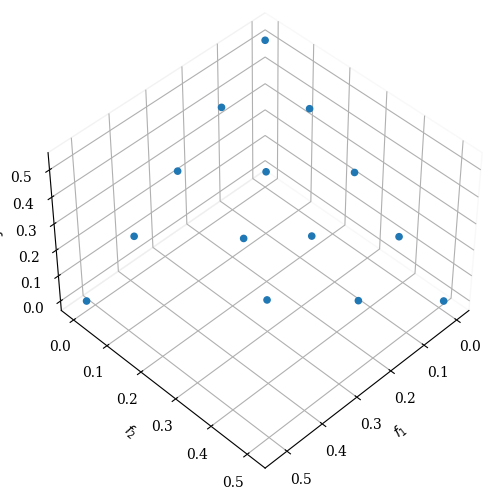

In [18]:
Scatter().add(res.F).show()

In [ ]:
PCP().add(res.F).show()

In [22]:
with open('pymoo_time_nsga3_dtlz1_92_500_3_4.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz1_92_500_3_4.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

n_gen  |  n_eval  |     x_time   
     1 |       91 |  0.0129494667
     2 |      182 |  0.0808508396
     3 |      273 |  0.0928511620
     4 |      364 |  0.1028501987
     5 |      455 |  0.1108496189
     6 |      546 |  0.1208510399
     7 |      637 |  0.1288502216
     8 |      728 |  0.1388494968
     9 |      819 |  0.1508488655
    10 |      910 |  0.1628525257
    11 |     1001 |  0.1788606644
    12 |     1092 |  0.1968483925
    13 |     1183 |  0.2108514309
    14 |     1274 |  0.2228486538
    15 |     1365 |  0.2392838001
    16 |     1456 |  0.2586932182
    17 |     1547 |  0.2697312832
    18 |     1638 |  0.2868094444
    19 |     1729 |  0.3007733822
    20 |     1820 |  0.3118505478
    21 |     1911 |  0.3218502998
    22 |     2002 |  0.3318505287
    23 |     2093 |  0.3438515663
    24 |     2184 |  0.3538520336
    25 |     2275 |  0.3618505001
    26 |     2366 |  0.3718502522
    27 |     2457 |  0.3818519115
    28 |     2548 |  0.3918852806
    29 |     2

   255 |    23205 |  3.0649905205
   256 |    23296 |  3.0994112492
   257 |    23387 |  3.1103370190
   258 |    23478 |  3.1203877926
   259 |    23569 |  3.1303884983
   260 |    23660 |  3.1423885822
   261 |    23751 |  3.1543886662
   262 |    23842 |  3.1643896103
   263 |    23933 |  3.1763899326
   264 |    24024 |  3.1883890629
   265 |    24115 |  3.2003877163
   266 |    24206 |  3.2103874683
   267 |    24297 |  3.2204303741
   268 |    24388 |  3.2323896885
   269 |    24479 |  3.2443902493
   270 |    24570 |  3.2543897629
   271 |    24661 |  3.2663872242
   272 |    24752 |  3.2809391022
   273 |    24843 |  3.2963988781
   274 |    24934 |  3.3066358566
   275 |    25025 |  3.3186044693
   276 |    25116 |  3.3286857605
   277 |    25207 |  3.3406856060
   278 |    25298 |  3.3506865501
   279 |    25389 |  3.3626861572
   280 |    25480 |  3.3726863861
   281 |    25571 |  3.3866860867
   282 |    25662 |  3.3986835480
   283 |    25753 |  3.4086840153
   284 |    25

   500 |    45500 |  5.9080297947


In [26]:
res.X[50]

array([0.99999949, 0.41661999, 0.50001196, 0.49999905])

## DTLZ 2

In [ ]:
NOBJ = 4
NDIM = 5
P = 7

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [ ]:
problem = DTLZ2(n_var=NDIM, n_obj=NOBJ)

In [ ]:
with open('pymoo_time_nsga3_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(algorithm_nsga3, algorithm, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

In [ ]:
with open('pymoo_time_nsga2_dtlz2_120_500_4_5.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz2_120_500_4_5.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3","f4"])
    start_time = time.time()
    res = minimize(algorithm_nsga2, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## DTLZ 3

In [ ]:
NOBJ = 6
NDIM = 6
P = 5

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [ ]:
problem = DTLZ3(n_var=NDIM, n_obj=NOBJ)

In [ ]:
with open('pymoo_time_nsga3_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz2_120_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

In [ ]:
with open('pymoo_time_nsga2_dtlz3_252_500_6_6.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz2_120_500_6_6.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3","f4","f5","f6"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

## DTLZ 7

In [ ]:
NOBJ = 3
NDIM = 10
P = 12

ref_dirs = get_reference_directions("das-dennis", NOBJ, n_partitions=P)
MU=ref_dirs.shape[0]

algorithm_nsga3 = NSGA3(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection=TournamentSelection(func_comp=comp_by_cv_then_random),
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  ref_dirs=ref_dirs,
                  eliminate_duplicates=False)

algorithm_nsga2 = NSGA2(pop_size=MU, 
                  sampling=FloatRandomSampling(), 
                  selection = TournamentSelection(func_comp=binary_tournament), 
                  crossover=SBX(prob=CXPB, eta=20.0, vtype=float), 
                  mutation=PolynomialMutation(prob=MUTPB, eta=20.0), 
                  eliminate_duplicates=False)

In [ ]:
problem = DTLZ7(n_var=NDIM, n_obj=NOBJ)

In [ ]:
with open('pymoo_time_nsga3_dtlz7_220_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga3_dtlz7_220_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga3, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)

In [ ]:
with open('pymoo_time_nsga2_dtlz7_220_500_3_10.csv', 'w', newline='') as f, open('pymoo_fitness_nsga2_dtlz7_220_500_3_10.csv','w', newline='') as g:
    writer = csv.writer(f)
    writer.writerow(["Execution Time"])
    
    writerFitness = csv.writer(g)
    writer.writerow(["f1","f2","f3"])
    start_time = time.time()
    res = minimize(problem, algorithm_nsga2, ('n_gen', NGEN), seed=1, output=measure_time(), verbose=True, save_history=False)
    
    for fitness in res.F:
            writerFitness.writerow(fitness)